In [19]:
from tkinter import messagebox
from tkinter import filedialog
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [20]:
def ui_load_ixxt_archive(file_path):
    # Se o caminho não for fornecido, abrir a caixa de diálogo para selecionar o arquivo
    if not file_path:
        file_path = filedialog.askopenfilename(
            title="Selecione o arquivo CSV",
            filetypes=(("CSV files", "*.CSV"), ("all files", "*.*"))
        )
    
    # Verificar se o caminho foi fornecido ou selecionado
    if file_path:
        df = ixxt_filetodataframe(file_path)  # Simulação do carregamento de dados
        return df
    else:
        print("Nenhum arquivo foi selecionado.")
        return None

In [21]:
def process_data(hex_data):
    # Verifica se a entrada é uma string
    if isinstance(hex_data, str):
        byte_list = hex_data.split(' ')

        # Verifica se a lista contém exatamente 8 itens
        if len(byte_list) < 8:
            byte_list.extend(['00'] * (8 - len(byte_list)))

        # Converte os valores de hexadecimal para decimal
        byte_list = [int(byte, 16) for byte in byte_list]

        return byte_list  # Retorna a lista para ser expandida em colunas
    else:
        raise ValueError("A entrada deve ser uma string hexadecimal.")


In [22]:
def ixxt_filetodataframe(file_path):
    df = pd.read_csv(file_path, sep=';', quotechar='"', skiprows=6)
    df = df.dropna(subset=['Data (hex)'])
    df['Identifier (hex)'] = df['Identifier (hex)'].apply(lambda x: int(x, 16))

    byte_columns = df['Data (hex)'].apply(process_data)
    
    byte_columns = pd.DataFrame(byte_columns.tolist(), index=df.index, columns=[f'byte_{i + 1}' for i in range(8)])
    print(byte_columns)
    columns_to_drop = ['Format', 'Flags', 'Time', 'Data (hex)']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    df = pd.concat([df, byte_columns], axis=1)
    df = df.rename(columns={'Identifier (hex)': 'pgn'})
    return df


In [23]:
def rows_replicate_dataframes(df):
    if 'x' in df.columns:
        # Cria um novo dataframe vazio para armazenar os valores repetidos
        df_result = pd.DataFrame(columns=['x'])
        
        # Primeiro loop para percorrer cada linha do dataframe original
        rows = []
        for i in range(len(df)):
            value = df.iloc[i, 0]  # Obtém o valor da primeira coluna (coluna 'x')
            
            # Segundo loop para repetir o valor 10 vezes
            for _ in range(20):
                rows.append(value)
        
        # Concatena as listas no DataFrame final
        df_result = pd.concat([pd.DataFrame({'x': rows})], ignore_index=True)
        
        return df_result
    else:
        return "Coluna 'x' não encontrada"

In [24]:
def decimacao_dinamica(df, coluna, tamanho):
    
    df[coluna] = df[coluna].apply(lambda x: list(map(int, x.split())) if isinstance(x, str) and x.strip() else [])

    def decimar_lista(lst, tamanho_fixo):
        if len(lst) == 0:
            print(f"Lista vazia, preenchendo com zeros até {tamanho_fixo} elementos.")
            return [0] * tamanho_fixo  # Se a lista estiver vazia, retorna uma lista de zeros
        elif len(lst) == tamanho_fixo:
            print(f"Lista já está no tamanho fixo ({tamanho_fixo}).")
            return lst  # Se já estiver no tamanho fixo, retorna a lista original
        elif len(lst) > tamanho_fixo:
            # Se a lista for maior, faz a decimação (subsample)
            step = len(lst) // tamanho_fixo  # Calcula o passo necessário
            decimated_lst = lst[::step][:tamanho_fixo]  # Fatiamento
            print(f"Lista maior que o tamanho' fixo ({len(lst)} > {tamanho_fixo}). Aplicando decimação.")
            print(f"Lista maior que o tamanho' fixo ({len(lst)} > {tamanho_fixo}). Aplicando decimação.")
            print(f"Lista decimada: {decimated_lst}")
            return decimated_lst
        else:
            # Se for menor, preenche com zeros até atingir o tamanho
            filled_lst = lst + [0] * (tamanho_fixo - len(lst))
            print(f"Lista menor que o tamanho fixo ({len(lst)} < {tamanho_fixo}). Preenchendo com zeros.")
            print(f"Lista preenchida: {filled_lst}")
            return filled_lst

    print(f"dataframe antes decimaçao:{df}")
    # Aplicar a decimação dinâmica na coluna
    df[coluna] = df[coluna].apply(lambda lst: decimar_lista(lst, tamanho))

    print("\nApós a decimação dinâmica:")
    print(df[coluna])

    return df

In [25]:
def normalizar_dataframe(df):
    if df_decimado is None or df_decimado.empty:
        print("Aviso: O DataFrame está vazio ou não foi carregado.")
        return None
    
    try:
        
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
        for i in range(len(df)):
            # Transformar a linha em um array 2D, pois o scaler espera isso
            #data = np.array(df_decimado['x'].iloc[i]).reshape(-1, 1)
            data = np.array(df.loc[i, 'x']).reshape(-1, 1)

            # Aplicar o fit_transform para a linha atual
            data_normalized = scaler.fit_transform(data)
            
            # Substituir a linha normalizada no DataFrame
            df_decimado.loc[i, 'x'] = data_normalized.flatten().tolist()


        return df_decimado
    except Exception as e:
        print(f"Erro ao normalizar o DataFrame: {str(e)}")
        return None


In [26]:
def filtrar_dataframe(df, pgn, byte):

    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return None

    if pgn and byte:
        try:
            filtered_df = df[df['pgn'] == int(pgn, 16)]  # Se pgn for uma string hexadecimal

            # Verificar se o byte filtrado existe
            if byte in filtered_df.columns:
                # Filtrar os valores do byte especificado que não são 'FF' (255 em decimal)
                filtered_df = filtered_df[[byte]]
                #filtered_df = filtered_df[filtered_df[filtro_byte] != 255]
                filtered_df = filtered_df.rename(columns={byte: 'x'})

                if not filtered_df.empty:
                    return filtered_df
                else:
                    messagebox.showinfo("Informação", "Nenhum valor diferente de FF encontrado após filtrar.")
                    return None
            else:
                messagebox.showinfo("Informação", f"A coluna {byte} não existe.")
                return None
        except Exception as e:
            messagebox.showerror("Erro", f"Erro ao aplicar filtros: {str(e)}")
            return None
    else:
        messagebox.showwarning("Aviso", "Preencha os campos de filtro antes de filtrar.")
        return None

In [27]:
def vizdata(df):
    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return

    # Visualização da coluna específica
    plt.figure(figsize=(20, 10), dpi=100)
    plt.plot(range(len(df)), df['x'], linestyle='-', color='b',
                linewidth=0.7, label='x')
    plt.xlabel('X')
    plt.ylabel('Value')
    plt.title(f"Visualização de Dados - PGN: {filtro_pgn}, Byte: {filtro_byte}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
def rotular_df(df, label):

    label_dict = {
        "Onda Quadrada": 1,
        "Onda Seno": 0,
    }

    # Verifica se o rótulo textual existe no dicionário
    if label not in label_dict:
        raise ValueError(f"Rótulo '{label}' não é válido. Use 'Onda Quadrada', 'Onda Seno' ou 'Onda Triangular'.")
    
    numeric_label = label_dict[label]

    if df is None:
        raise ValueError("O dataframe está vazio, carrega 'treino'")
    else:
        # Preencher o DataFrame com o valor numérico correspondente
        rotuled_df = df.copy()
        rotuled_df['label'] = numeric_label

    return rotuled_df


In [29]:
def concatenate_dataframes(df_list):
    rows = []
    
    # Iterar sobre cada DataFrame na lista
    for df in df_list:
        # Concatenar os valores da coluna 'X' em ma única célula
        concatenated_x = ' '.join(map(str, df['x'].tolist()))
        # Adicionar à lista de resultados como um dicionário
        rows.append({'x': concatenated_x})
    
    # Converter a lista de dicionários para um DataFrame
    concatenated_df = pd.DataFrame(rows)
    
    return concatenated_df

In [30]:
def plot_line_for_each_row(df):
    if 'x' not in df.columns:
        raise ValueError("O DataFrame deve conter uma coluna 'x'")
    
    # Iterar sobre cada linha do DataFrame
    for index, row in df.iterrows():
        # Como a coluna 'x' já contém listas de valores, podemos usá-las diretamente
        values = row['x']  # Já é uma lista de floats ou inteiros
        
        plt.plot(values, label=f"Sinal {index + 1}")
    
    # Adicionar rótulos e título ao gráfico
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.title("Gráfico de Linhas para Cada Linha do DataFrame")
    plt.legend()
    plt.show()

In [31]:
def save_df_train(train_df):
    if train_df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return

    save_path = filedialog.asksaveasfilename(
        defaultextension=".csv",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
        title="Salvar o DataFrame de treino completo"
    )

    if save_path:
        train_df.to_csv(save_path, index=False)
        messagebox.showinfo("Sucesso", "DataFrame de treino salvo com sucesso!")

# IXXT-SquareWaves

# JUMPY 2024
## Velocidade

In [32]:
df_raw_1 = ui_load_ixxt_archive("JUMPY 2024/velocidade_0_20_5x_jumpy.CSV")  #26s #29,5 #30,7 #42,6

FileNotFoundError: [Errno 2] No such file or directory: 'JUMPY 2024/velocidade_0_20_5x_jumpy.CSV'

In [317]:
filtro_byte = 3
filtro_pgn = '32d'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

byte_3 e 32d


In [318]:
filtered_df_one = filtrar_dataframe(df_raw_1, filtro_pgn, filtro_byte)

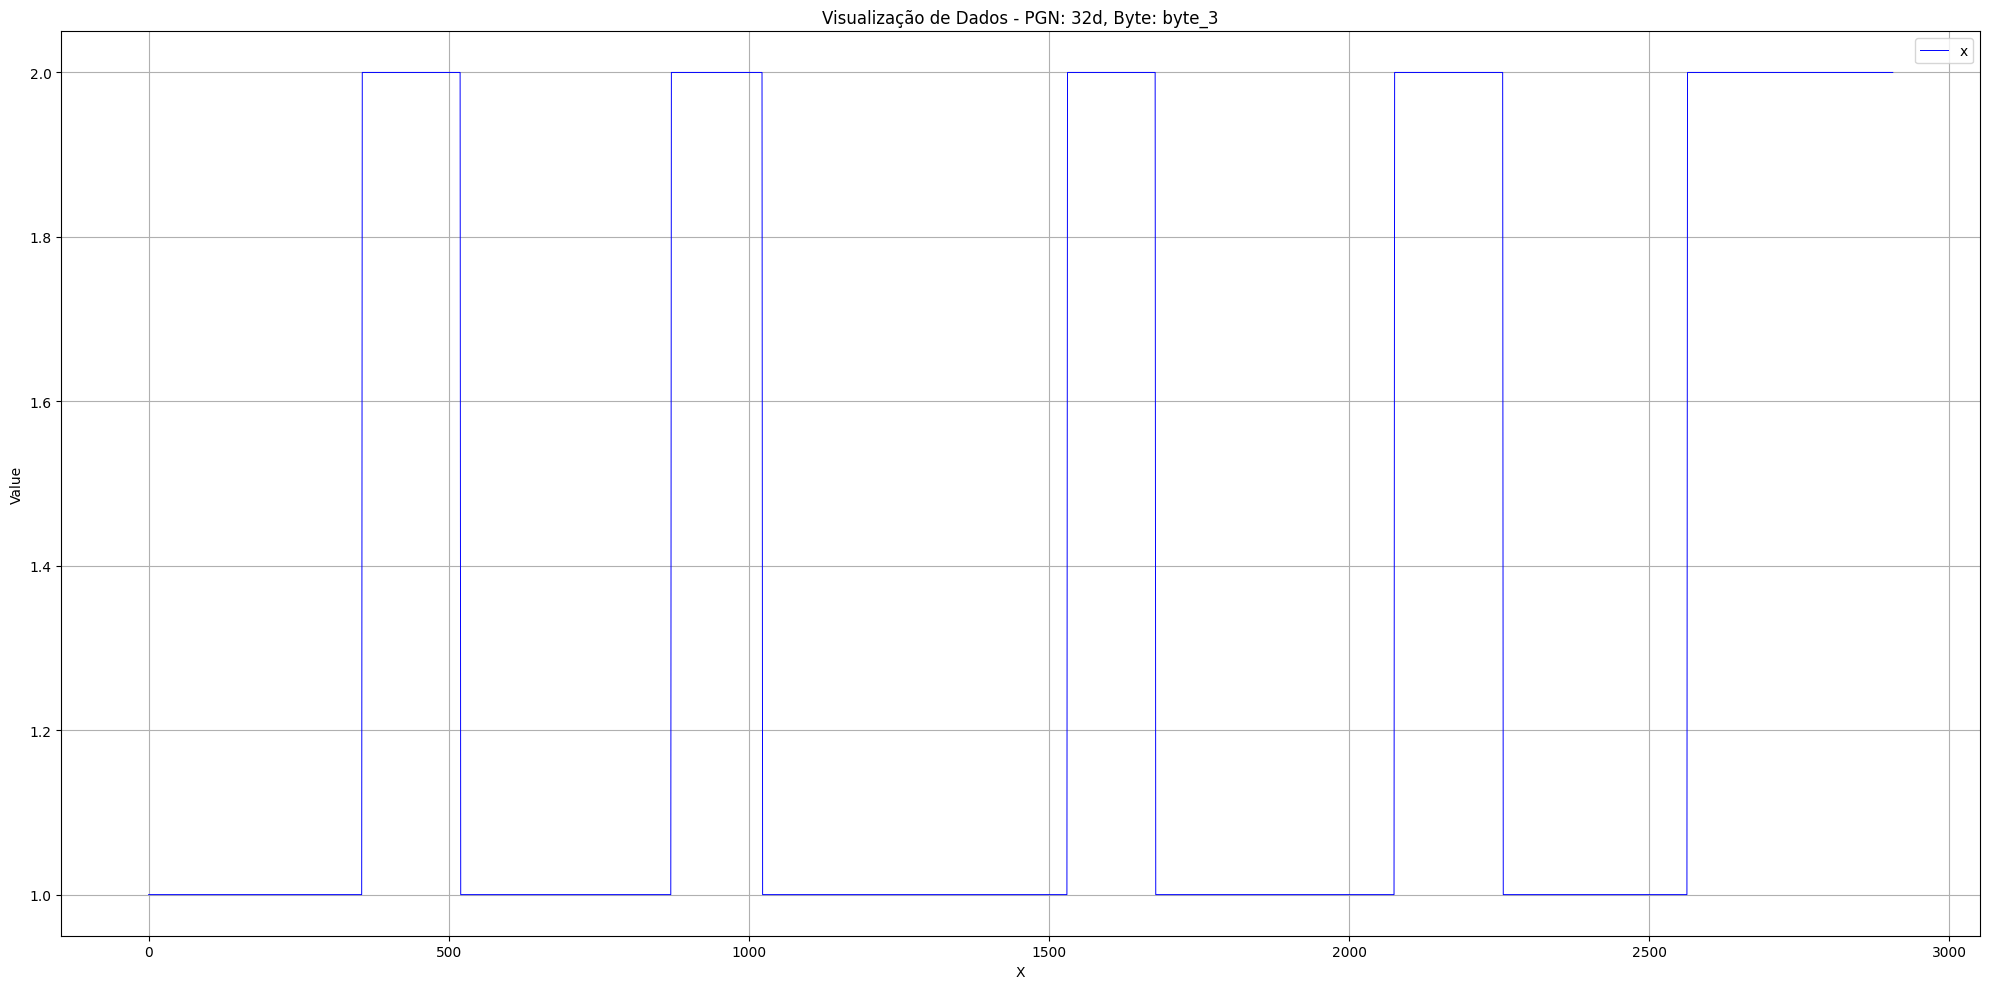

In [319]:
vizdata(filtered_df_one)

## Freio

In [320]:
df_raw_2 = ui_load_ixxt_archive("JUMPY 2024/pedal_freio_5x_jumpy.CSV") 

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0         255     253       0       0      11      34      96     185
1         127     192       1       0     128       0       0       0
2           0       0      50       0      12      50      50      50
3          50       0       0      55       0       4       0       0
4         255     196       0       7      75       0      32       0
...       ...     ...     ...     ...     ...     ...     ...     ...
13182       0       0      50       0      12      50      50      50
13183      50       0       0      55       0       4       0       0
13184       0      50      41      50     193       1      68       0
13185     255     196       0       7      75       0      32       0
13186       8       0       0       0       0       0       0       0

[13187 rows x 8 columns]


In [321]:
filtro_byte = 5
filtro_pgn = '208'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

byte_5 e 208


In [322]:
filtered_df_two = filtrar_dataframe(df_raw_2, filtro_pgn, filtro_byte)

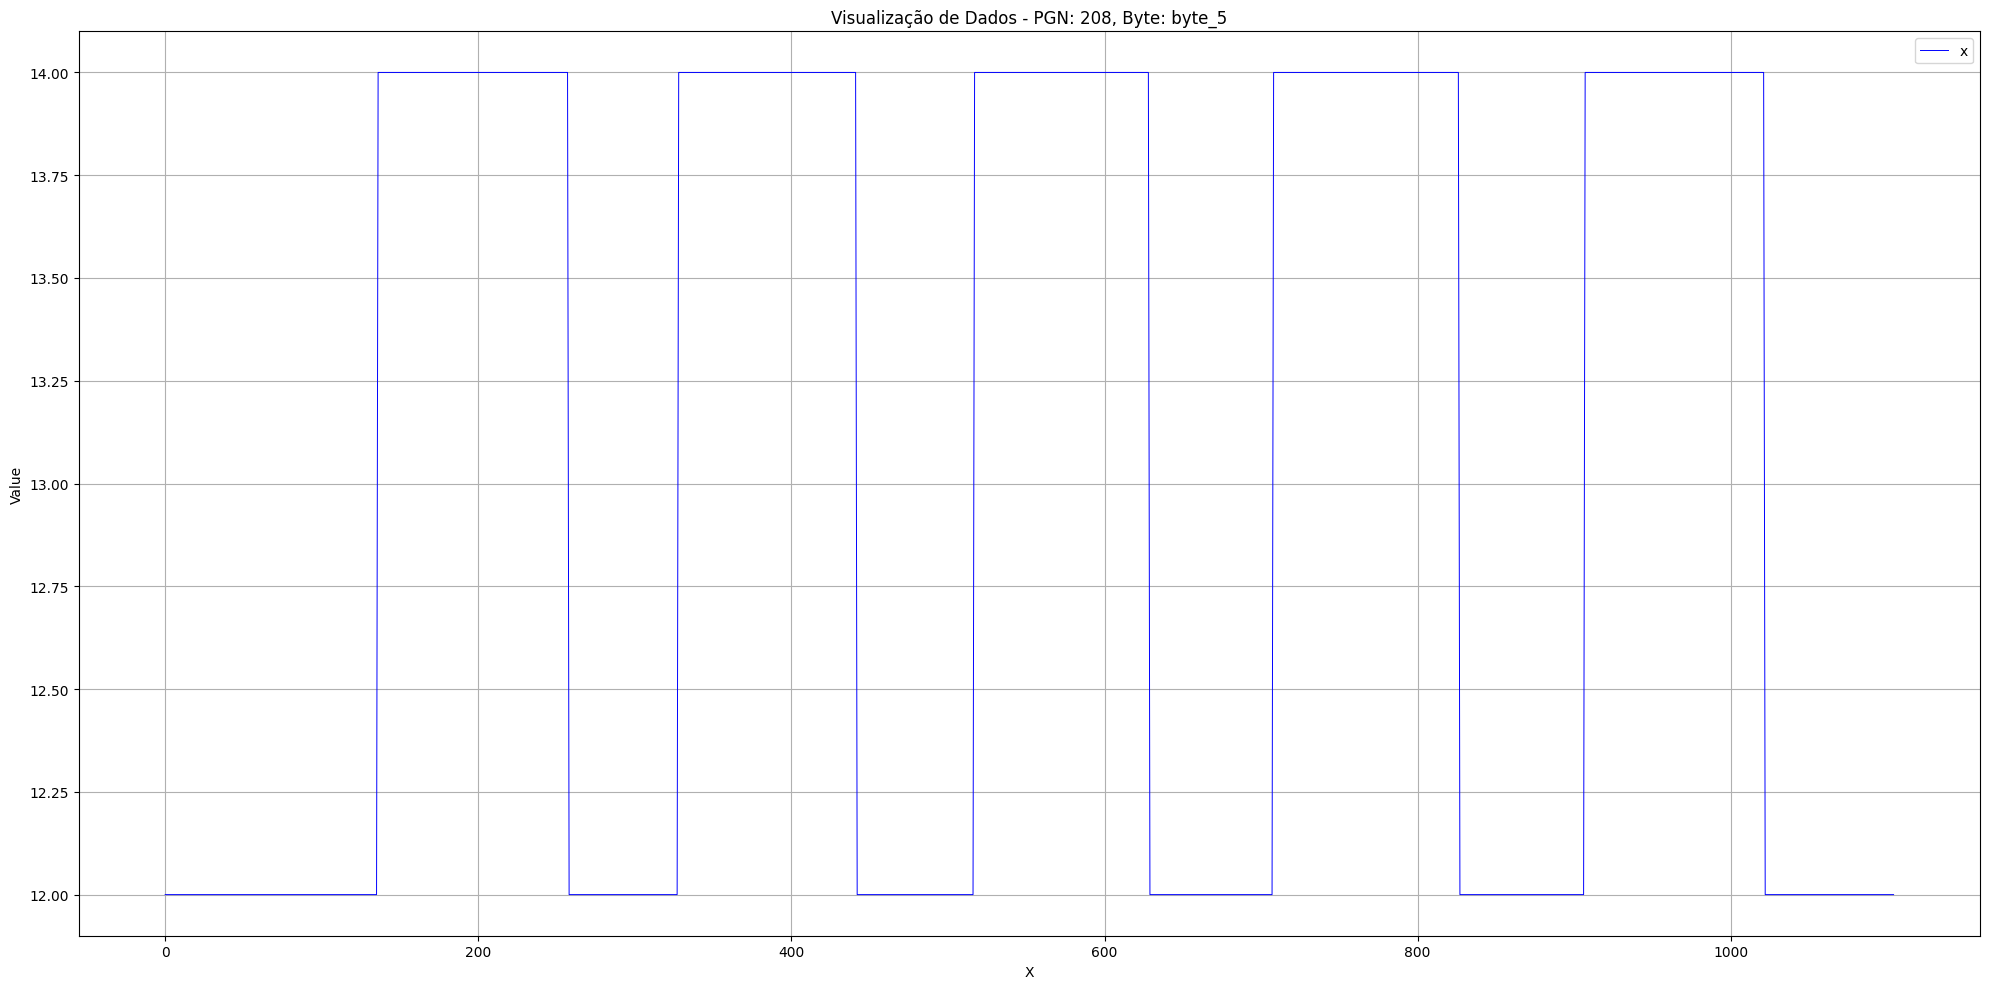

In [323]:
vizdata(filtered_df_two)

## Limpador

In [324]:
df_raw_3 = ui_load_ixxt_archive('JUMPY 2024/limpador_vel1_5x_jumpy.CSV') 

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0          93       0       0       0       0       0       0       0
1           0       0       0       0     175     215      70       0
2           0       0       0       0       0       0       0       0
3         255     195       0       7     196       0      32       0
4          25     168      49       0      76      50      49      49
...       ...     ...     ...     ...     ...     ...     ...     ...
16069     127     192       1       0     128       0       0       0
16070      25     128      47       0      76      50      47      47
16071      47      48       0     138       0     161      32       0
16072      50       0     240       0       0       0       0       0
16073     255     195       0       7     110       0      32       0

[16074 rows x 8 columns]


In [325]:
filtro_byte = 2
filtro_pgn = '348'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

byte_2 e 348


In [326]:
filtered_df_three = filtrar_dataframe(df_raw_3, filtro_pgn, filtro_byte)
df_expanded_three = rows_replicate_dataframes(filtered_df_three)
filtered_df_three.head()

,x
17,37
36,37
63,37
83,37
108,37


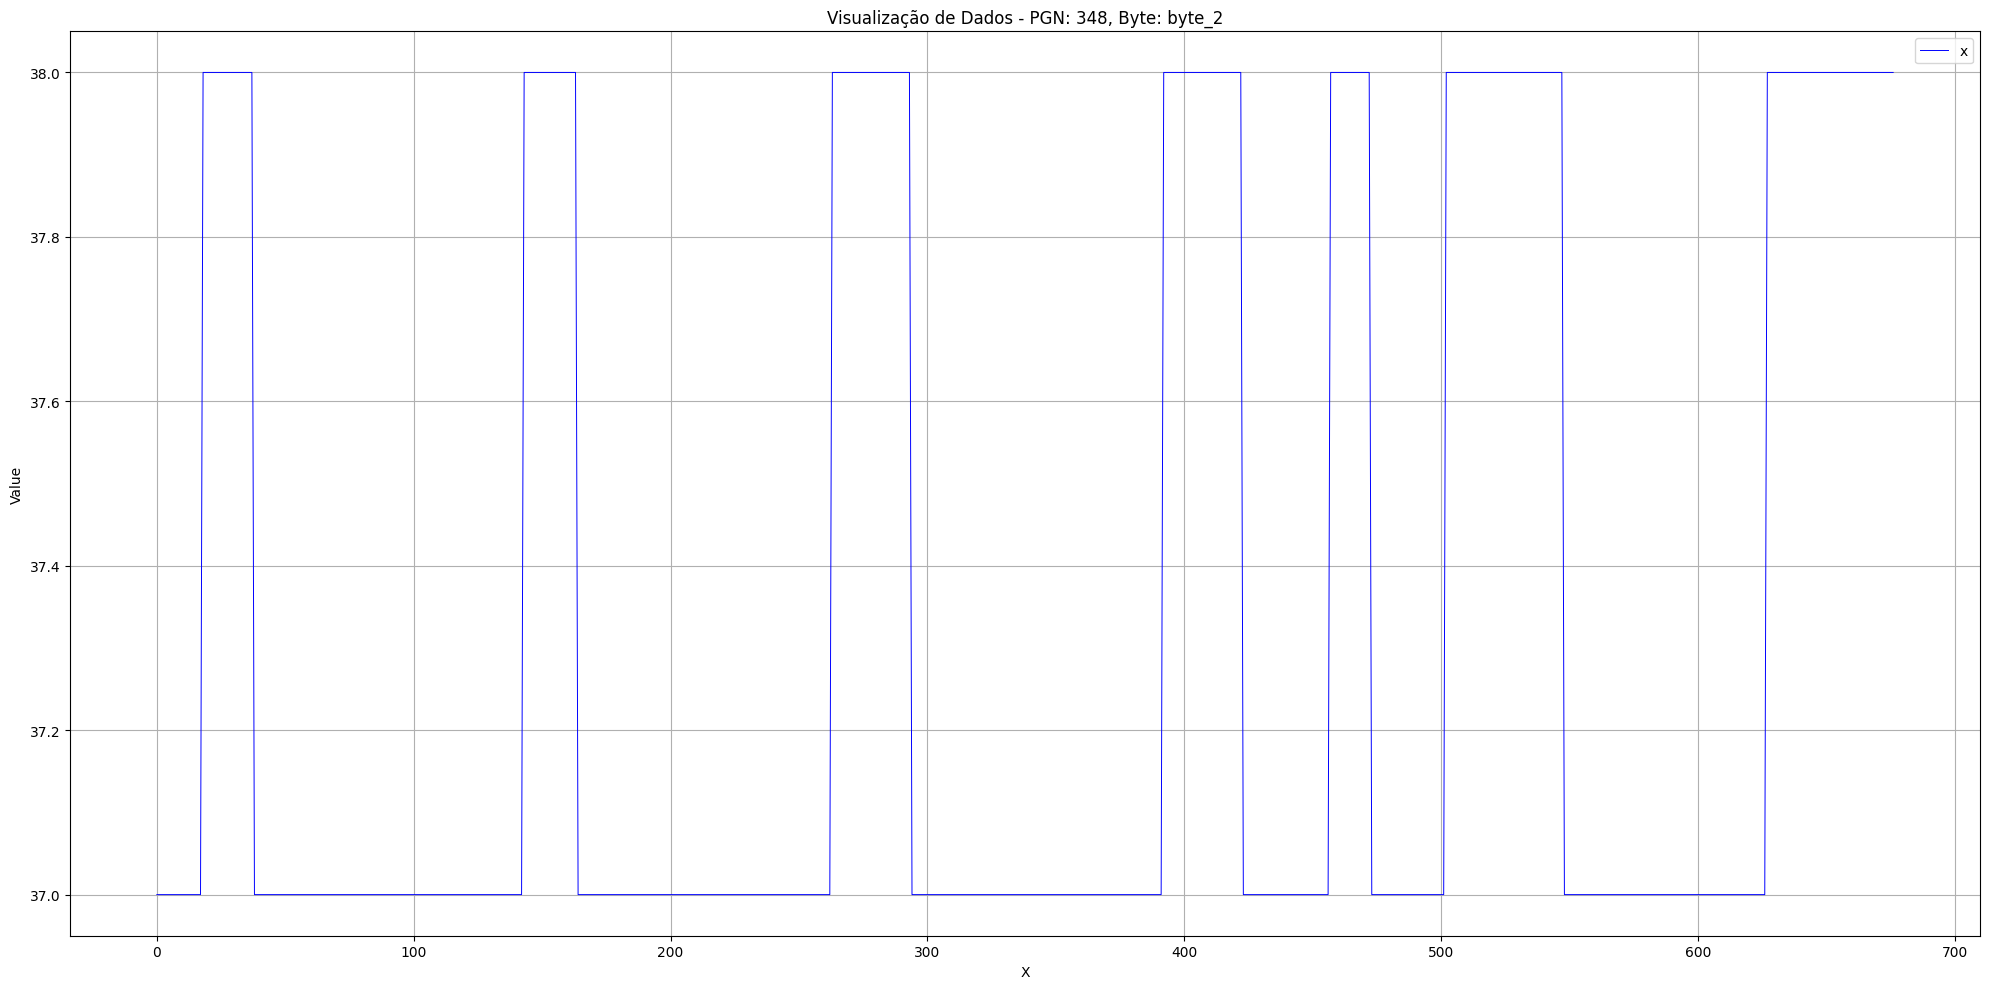

In [327]:
vizdata(filtered_df_three)

# KALMAR
## Limpador

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0           0       0       0       0       0       0       0       0
1           2      80     154       9       0       0       0       0
2           7     211       0      31       0       0       0       0
3           0       0       0       0       0       3       0       0
4         125       0       0       0       0      16       0       0
...       ...     ...     ...     ...     ...     ...     ...     ...
18243      11     173     178      51       0       0       0       0
18244      12       0     217      27       0       0       0       0
18245       2      80     154       9       0       0       0       0
18246     160      19     124       5     197      12     108      16
18247      96       0       0       0       0     144       1       0

[18248 rows x 8 columns]
byte_4 e 511


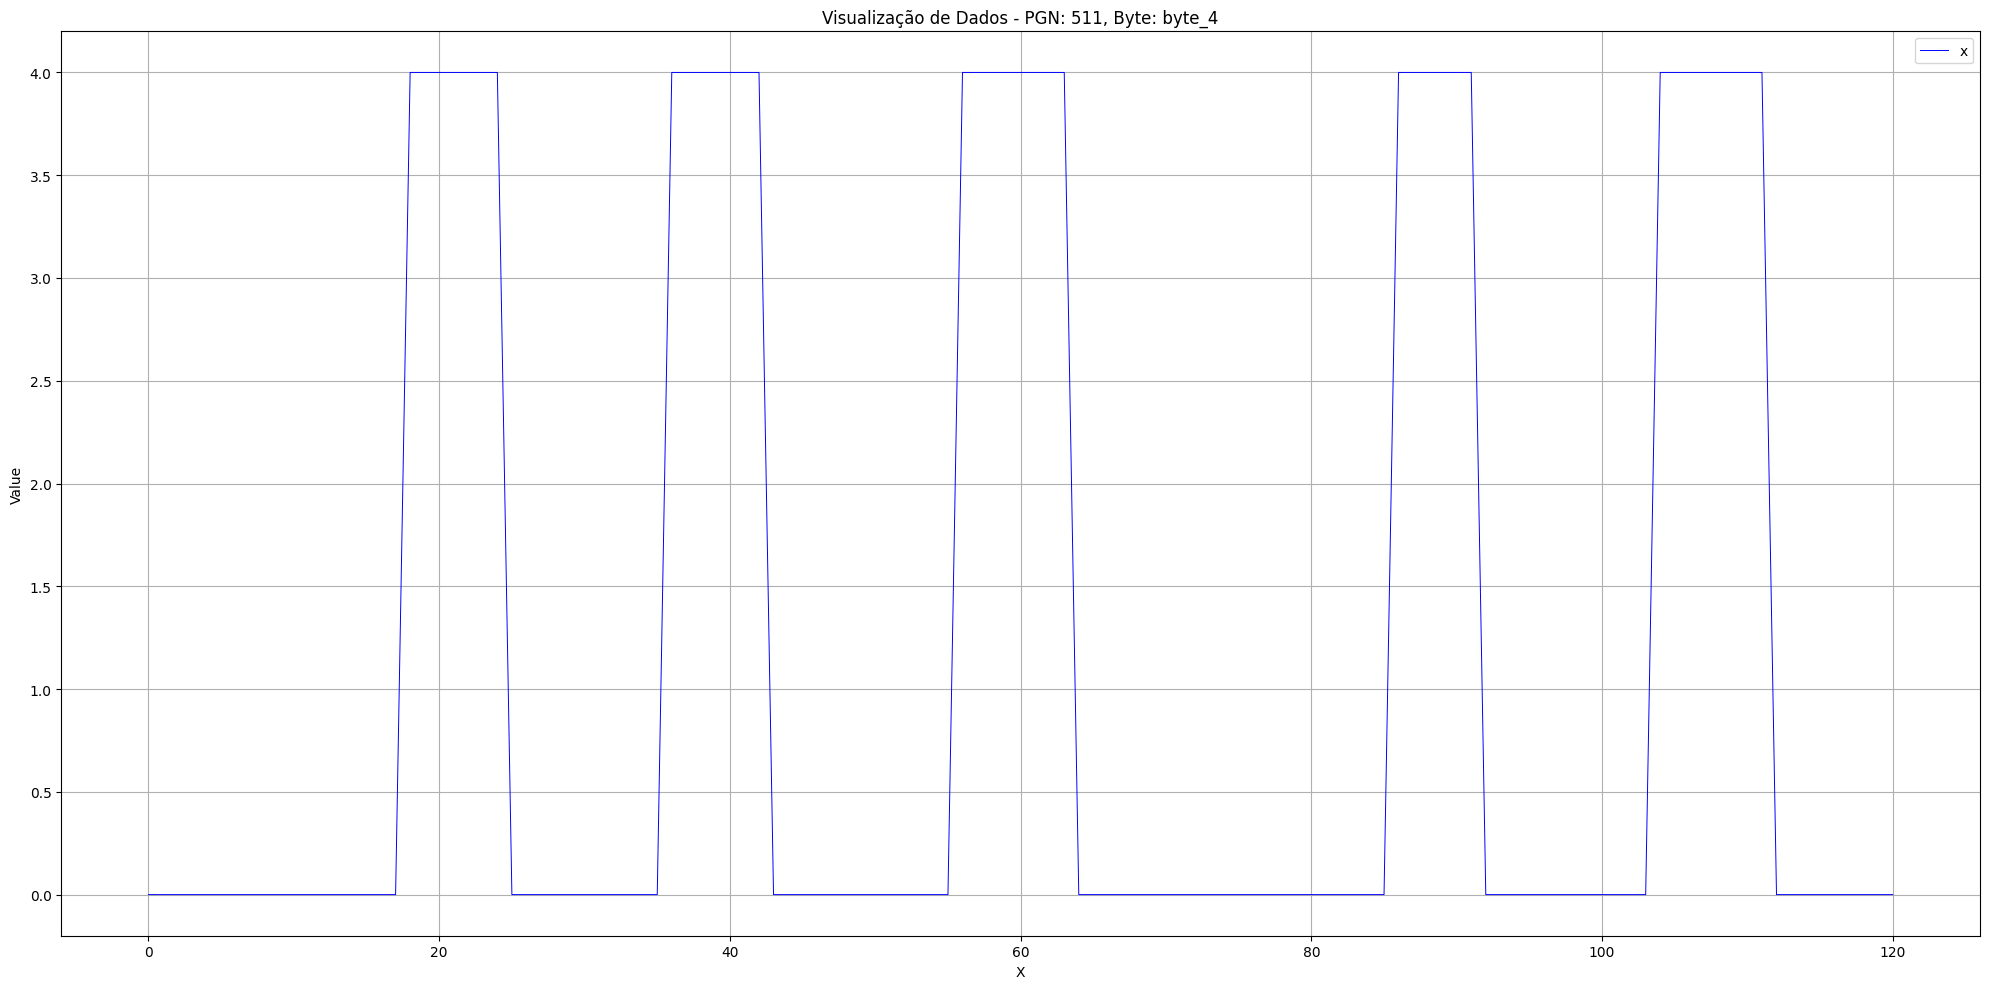

In [328]:
#Limpador
df_raw_4 = ui_load_ixxt_archive('KALMAR DRG540-65/LIMPADOR 5x.CSV')
filtro_byte = 4
filtro_pgn = '511'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")
filtered_df_Four = filtrar_dataframe(df_raw_4, filtro_pgn, filtro_byte)
filtered_df_Four.head()
vizdata(filtered_df_Four)

In [329]:
df_expanded_four = rows_replicate_dataframes(filtered_df_Four)

# Can-SquareWaves

In [330]:
def ui_load_can_archive(file_path=None):
    # Se o caminho não for fornecido, abrir a caixa de diálogo para selecionar o arquivo
    if not file_path:
        file_path = filedialog.askopenfilename(
            title="Selecione o arquivo .CAN ou .TXT",
            filetypes=(("CAN files", "*.can"), ("TXT files", "*.txt"), ("all files", "*.*"))
        )
    if file_path:
        df = can_filetodataframe(file_path)  # Carrega os dados do arquivo
        return df
    else:
        print("Nenhum arquivo foi selecionado.")
        return None

In [331]:
def process_data(hex_data):
    # Verifica se a entrada é uma string
    if isinstance(hex_data, str):
        byte_list = hex_data.split(' ')

        # Verifica se a lista contém exatamente 8 bytes
        if len(byte_list) < 8:
            byte_list.extend(['00'] * (8 - len(byte_list)))

        # Converte os valores de hexadecimal para decimal, ignorando inválidos
        byte_list = [int(byte, 16) if is_valid_hex(byte) else 0 for byte in byte_list]

        return byte_list  # Retorna a lista de bytes convertida
    else:
        raise ValueError("A entrada deve ser uma string hexadecimal.")

In [332]:
def is_valid_hex(value):
    """Função para verificar se o valor é hexadecimal válido"""
    try:
        int(value, 16)
        return True
    except ValueError:
        return False

In [333]:
def can_filetodataframe(file_path):
    try:
        # Ler o arquivo .txt linha a linha
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Separar as colunas por ';' e montar a lista de dados
        data = []
        for line in lines:
            # Ignorar as linhas de cabeçalho e as que não têm a quantidade esperada de colunas
            if line.startswith("//") or "Logging" in line or "Microchip" in line:
                continue

            # Dividir os valores por ';'
            parts = line.strip().split(';')

            # Garantir que tenha o número mínimo de colunas para processar (pelo menos 5)
            if len(parts) < 5:
                continue

            # Extrair o ID e os bytes
            pgn = parts[2]  # PGN (ID)
            byte_count = int(parts[3])  # Número de bytes
            byte_values = parts[4:4 + byte_count]  # Extraindo os bytes reais

            # Preencher com '00' caso não tenha 8 bytes
            if len(byte_values) < 8:
                byte_values.extend(['00'] * (8 - len(byte_values)))

            # Adicionar a linha processada (PGN + 8 bytes)
            data.append([pgn] + byte_values[:8])  # Garantir que tenha no máximo 8 bytes

        # Converter a lista de dados em um DataFrame
        df = pd.DataFrame(data, columns=['pgn', 'Byte 1', 'Byte 2', 'Byte 3', 'Byte 4',
                                         'Byte 5', 'Byte 6', 'Byte 7', 'Byte 8'])

        # Aplicar a conversão de hexadecimal para decimal nas colunas de bytes e no PGN
        for i in range(1, 9):
            df[f'Byte {i}'] = df[f'Byte {i}'].apply(lambda x: int(x, 16) if is_valid_hex(x) else 0)

        # Converter o PGN de hexadecimal para decimal
        df['pgn'] = df['pgn'].apply(lambda x: int(x, 16) if is_valid_hex(x) else 0)

        return df

    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return None


In [334]:
def filtrar_dataframe(df, pgn, byte):
    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return None

    if pgn and byte:
        try:
            filtered_df = df[df['pgn'] == pgn]  # Se pgn for uma string hexadecimal
            # Verificar se o byte filtrado existe
            if byte in filtered_df.columns:
                # Filtrar os valores do byte especificado que não são 'FF' (255 em decimal)
                filtered_df = filtered_df[[byte]]
                #filtered_df = filtered_df[filtered_df[filtro_byte] != 255]
                filtered_df = filtered_df.rename(columns={byte: 'x'})

                if not filtered_df.empty:
                    return filtered_df
                else:
                    messagebox.showinfo("Informação", "Nenhum valor diferente de FF encontrado após filtrar.")
                    return None
            else:
                messagebox.showinfo("Informação", f"A coluna {byte} não existe.")
                return None
        except Exception as e:
            messagebox.showerror("Erro", f"Erro ao aplicar filtros: {str(e)}")
            return None
    else:
        messagebox.showwarning("Aviso", "Preencha os campos de filtro antes de filtrar.")
        return None

In [335]:
def rows_replicate_dataframes(df, target_size):
    if 'x' in df.columns:
        num_rows = len(df)  # Número de linhas no dataframe original
        #df_result = pd.DataFrame(columns=['x'])
        
        replication_factor = target_size // num_rows
        #remainder = target_size % num_rows  # Calcula o restante para garantir exatamente 2000 linhas

        # Primeiro loop para percorrer cada linha do dataframe original
        rows = []
        for i in range(len(df)):
            value = df.iloc[i, 0]  # Obtém o valor da primeira coluna (coluna 'x')

            # Segundo loop para repetir o valor 10 vezes
            for _ in range(replication_factor):
                rows.append(value)

        # Concatena as listas no DataFrame final
        df_result = pd.concat([pd.DataFrame({'x': rows})], ignore_index=True)

        return df_result
    else:
        return "Coluna 'x' não encontrada"


In [336]:
# def rows_replicate_dataframes(df, target_size):
#     num_rows = len(df)  # Número de linhas no dataframe original
#     
#     if num_rows == 0:
#         return "O dataframe está vazio"
#     
#     if 'x' not in df.columns:
#         return "Coluna 'x' não encontrada"
#     
#     # Calcula quantas vezes cada linha deve ser replicada
# 
#     
#     # Primeiro, replica as linhas 'replication_factor' vezes
#     df_replicated = pd.DataFrame(df.loc[df.index.repeat(replication_factor)].reset_index(drop=True))
#     
#     # Se houver um restante, adiciona linhas adicionais até completar as 2000
#     if remainder > 0:
#         additional_rows = df.sample(n=remainder, replace=True).reset_index(drop=True)
#         df_replicated = pd.concat([df_replicated, additional_rows], ignore_index=True)
#     
#     return df_replicated

# Corolla Hybrid
## Freio

In [337]:
filtro_byte = 5
filtro_pgn = 865
filtro_byte = f'Byte {filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

Byte 5 e 865


In [338]:
df_raw_5 = ui_load_can_archive("corolla/freio_5x_logFile.CAN")
df_raw_5.head()

,pgn,Byte 1,Byte 2,Byte 3,Byte 4,Byte 5,Byte 6,Byte 7,Byte 8
0,608,0,0,10,249,157,0,134,144
1,740,160,0,0,0,139,0,0,0
2,32,0,0,7,43,0,0,0,0
3,36,2,0,2,0,66,4,128,246
4,37,15,194,0,0,144,0,0,142


In [339]:
filtered_df_five = filtrar_dataframe(df_raw_5, filtro_pgn, filtro_byte)
#vizdata(filtered_df_five)

In [340]:
df_expanded_five = rows_replicate_dataframes(filtered_df_five, target_size=1100)

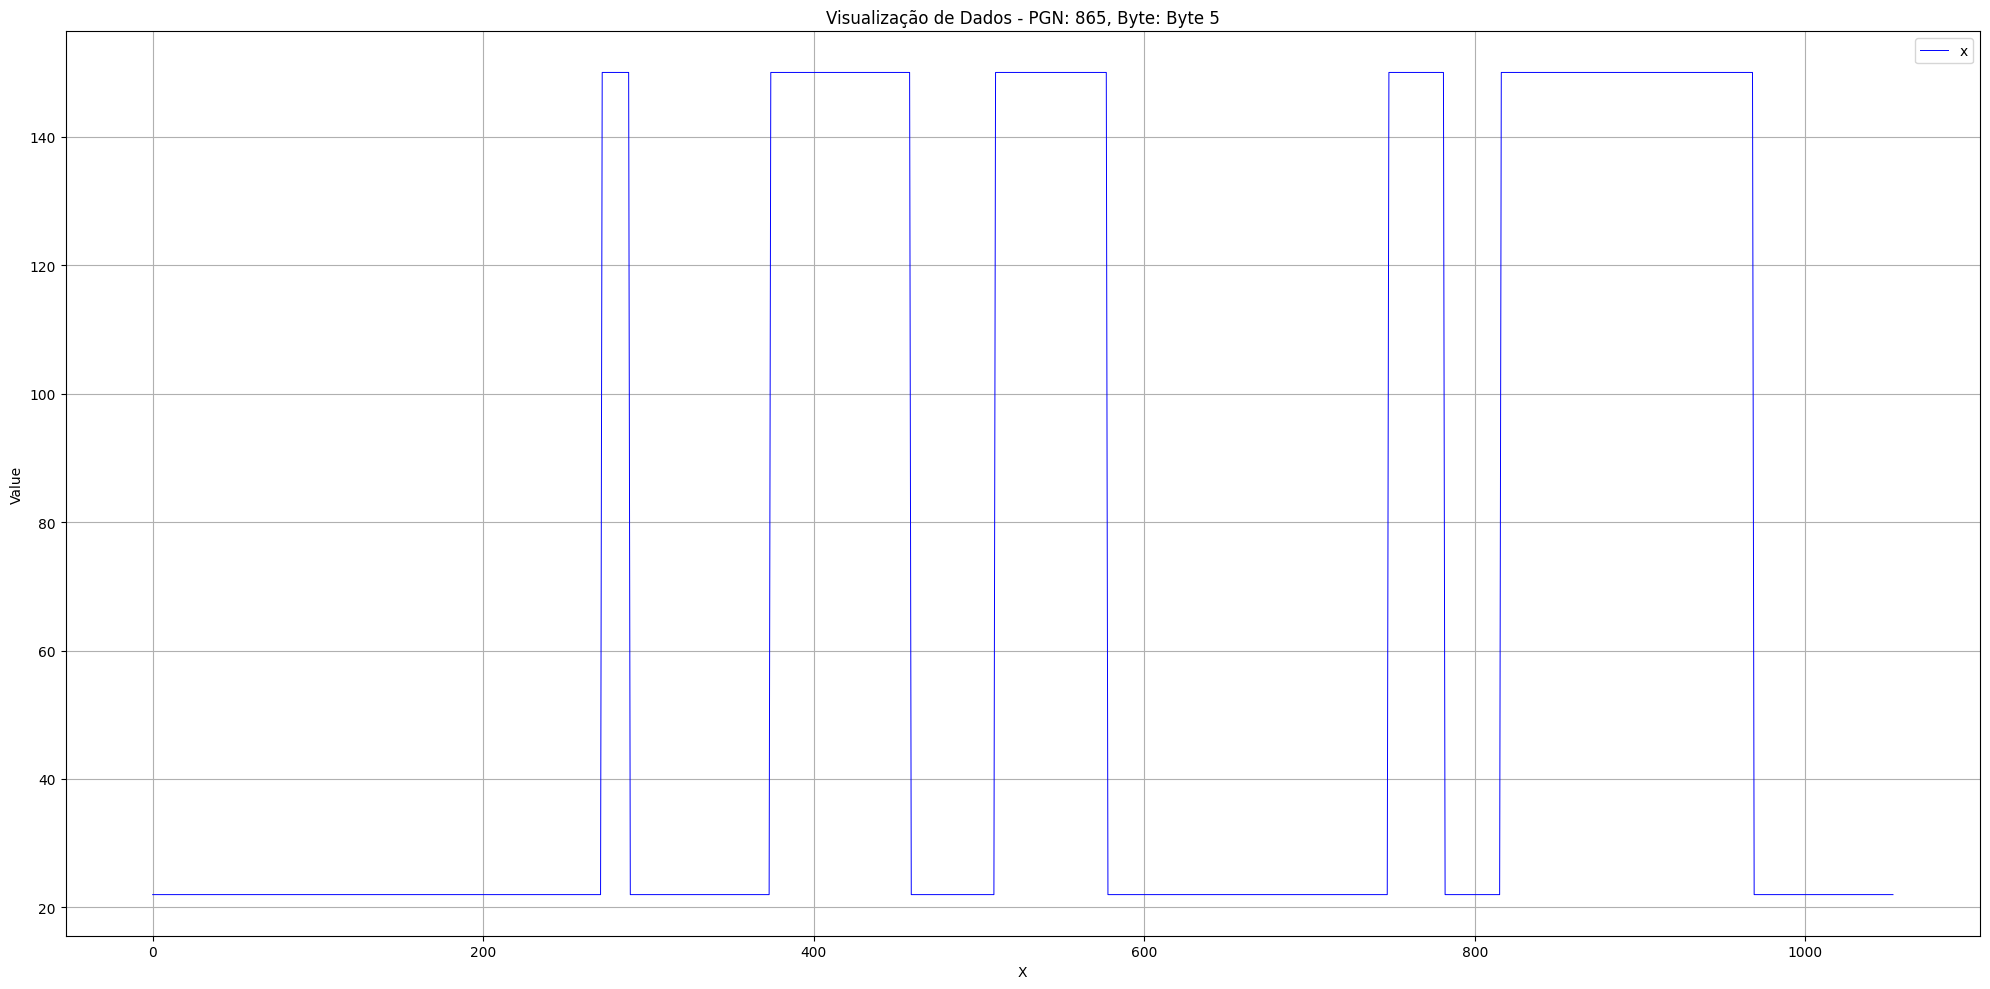

In [341]:
vizdata(df_expanded_five)

In [342]:
byte = 1
filtro_pgn = 971
filtro_byte = f'Byte {byte}'
print(f"{filtro_byte} e {filtro_pgn}")

Byte 1 e 971


In [343]:
df_raw_2 = ui_load_can_archive("corolla/limpador_5x_Corolla_logFile.CAN")
filtered_df_six = filtrar_dataframe(df_raw_2, filtro_pgn, filtro_byte)

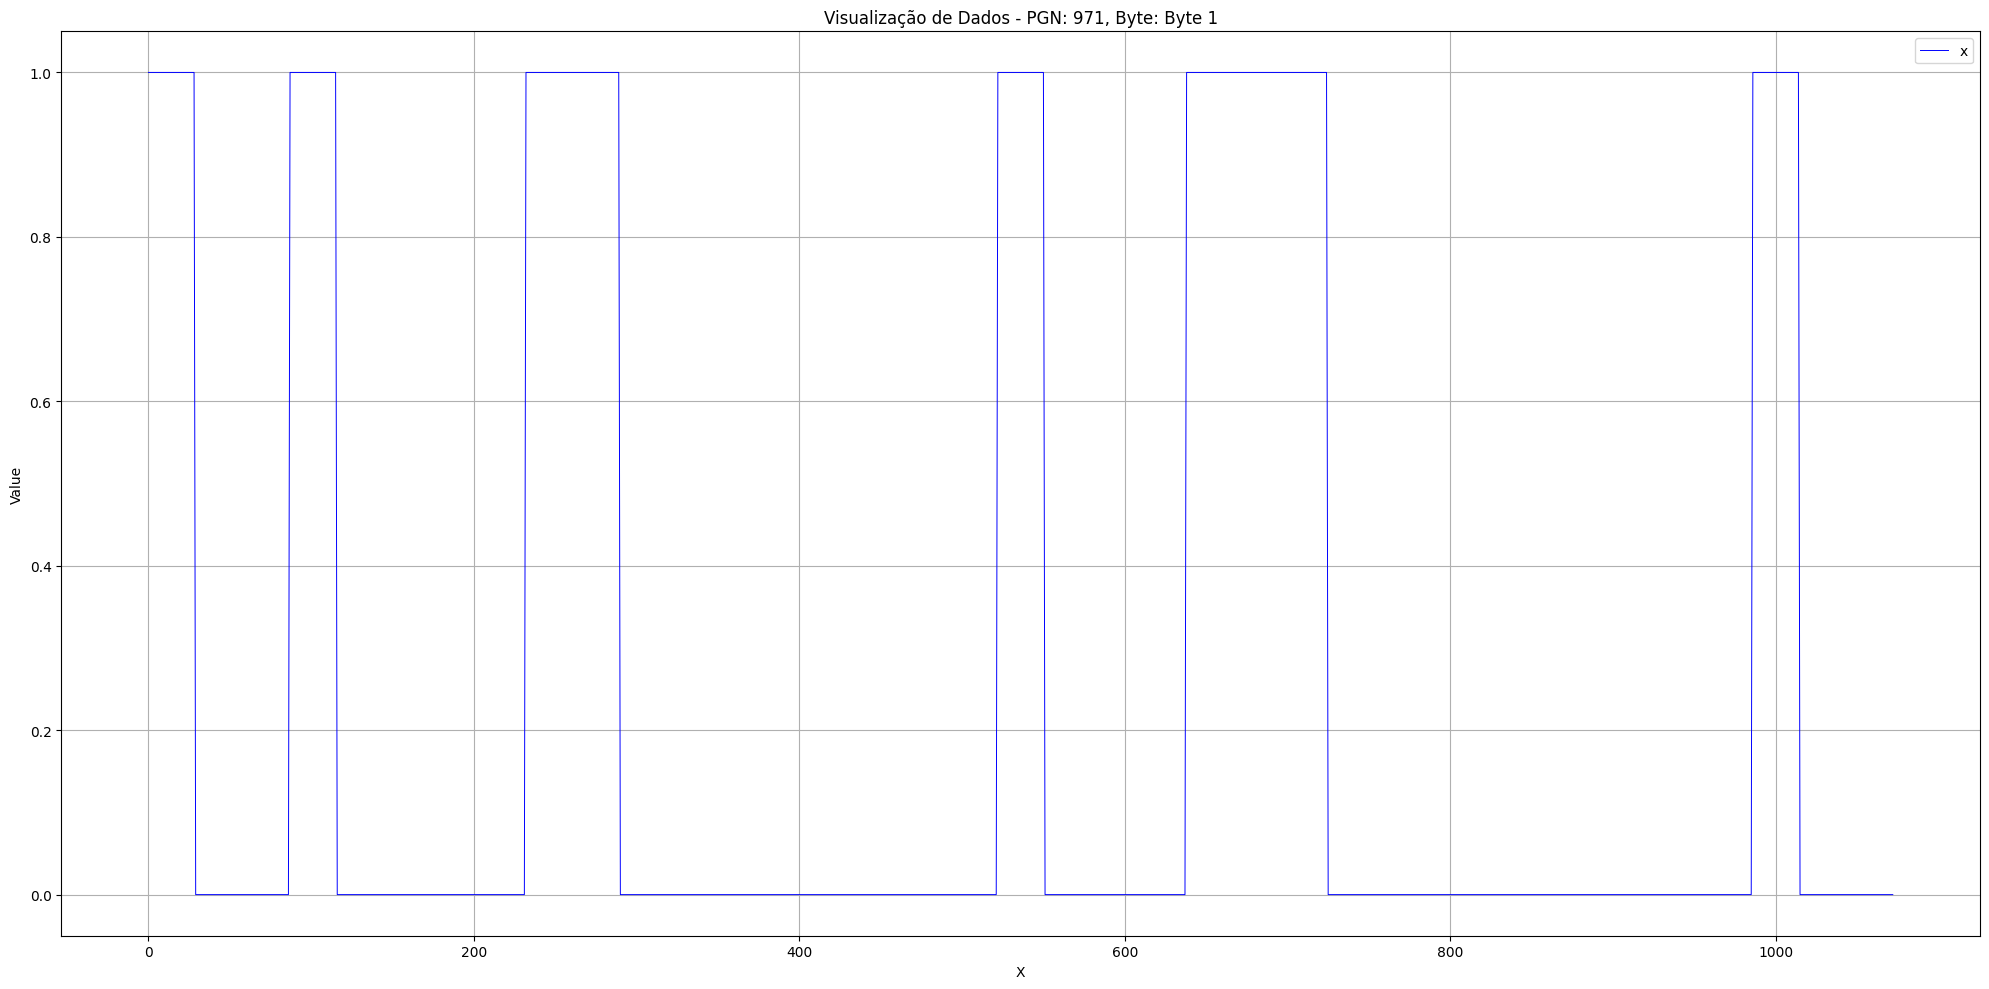

In [345]:
df_expanded_six = rows_replicate_dataframes(filtered_df_six, target_size=1100)
vizdata(df_expanded_six)

# Cluster

In [346]:
df_list = [filtered_df_one, filtered_df_two, df_expanded_three, df_expanded_four, df_expanded_five, df_expanded_six]
df_concatenate = concatenate_dataframes(df_list)

In [347]:
df_decimado = decimacao_dinamica(df_concatenate, 'x', 900)
normalized_df = normalizar_dataframe(df_decimado)

dataframe antes decimaçao:                                                   x
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1  [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...
2  [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2...
5  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Lista maior que o tamanho fixo (2907 > 900). Aplicando decimação.
Lista decimada: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

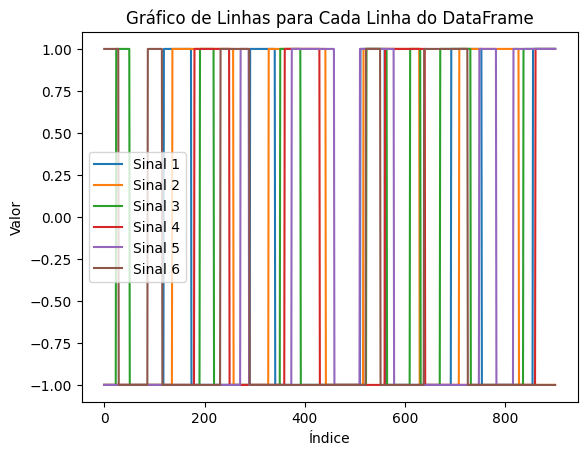

In [348]:
labeled_df = rotular_df(normalized_df, "Onda Quadrada")
plot_line_for_each_row(labeled_df)

In [349]:
print(labeled_df.tail())

                                                   x  label
1  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....      1
2  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....      1
3  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....      1
4  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....      1
5  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1


In [39]:
def save_df_train(train_df):
    if train_df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return

    save_path = filedialog.asksaveasfilename(
        defaultextension=".csv",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
        title="Salvar o DataFrame de treino completo"
    )

    if save_path:
        train_df.to_csv(save_path, index=False)
        messagebox.showinfo("Sucesso", "DataFrame de treino salvo com sucesso!")

In [40]:
save_df_train(labeled_df)

NameError: name 'labeled_df' is not defined

In [46]:
def can_filetodataframe(file_path):
    try:
        # Ler o arquivo .txt linha a linha
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Lista para armazenar os dados processados
        data = []
        for line in lines:
            # Ignorar as linhas de cabeçalho que contêm texto não processável
            if line.startswith("Time") or "ID(hex)" in line or "ASCII" in line or not line.strip():
                continue

            # Dividir os valores por espaços ou múltiplos espaços
            parts = line.split()

            # Verificar se a linha tem pelo menos 5 colunas para processar
            if len(parts) < 5:
                continue

            # Verificar se o valor de ID(hex) é realmente hexadecimal
            pgn = parts[1]
            if not is_valid_hex(pgn):
                continue  # Ignorar linhas com IDs que não são hexadecimais

            byte_count = int(parts[3].strip('[]'))  # Número de bytes
            byte_values = parts[4:4 + byte_count]  # Extrair os bytes reais

            # Preencher com '00' caso não tenha 8 bytes
            if len(byte_values) < 8:
                byte_values.extend(['00'] * (8 - len(byte_values)))

            # Adicionar a linha processada (PGN + 8 bytes)
            data.append([pgn] + byte_values[:8])  # Garantir que tenha no máximo 8 bytes

        # Converter a lista de dados em um DataFrame
        df = pd.DataFrame(data, columns=['pgn', 'Byte 1', 'Byte 2', 'Byte 3', 'Byte 4',
                                         'Byte 5', 'Byte 6', 'Byte 7', 'Byte 8'])

        # Aplicar a conversão de hexadecimal para decimal nas colunas de bytes e no PGN
        for i in range(1, 9):
            df[f'Byte {i}'] = df[f'Byte {i}'].apply(lambda x: int(x, 16) if is_valid_hex(x) else 0)

        # Converter o PGN de hexadecimal para decimal
        df['pgn'] = df['pgn'].apply(lambda x: int(x, 16) if is_valid_hex(x) else 0)

        return df

    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return None

In [47]:
def ui_load_can_archive():
    # Se o caminho não for fornecido, abrir a caixa de diálogo para selecionar o arquivo
    file_path = filedialog.askopenfilename(
        title="Selecione o arquivo",
        filetypes=(("TXT files", "*.txt"), ("all files", "*.*"))
    )
    if file_path:
        can_data = can_filetodataframe(file_path)  # Carrega os dados do arquivo terceiro tipo
        messagebox.showinfo("Sucesso", f"Arquivo '{file_path}' carregado com sucesso!")
    else:
        messagebox.showwarning("Aviso", "Nenhum arquivo foi selecionado.")


In [48]:
def is_valid_hex(value):
    """Função para verificar se o valor é hexadecimal válido"""
    try:
        int(value, 16)
        return True
    except ValueError:
        return False


In [49]:
def can_process_data(data_hex):
    bytes_list = data_hex.strip().split()

    # Preencher com '00' até que tenha 8 bytes
    if len(bytes_list) < 8:
        bytes_list.extend(['00'] * (8 - len(bytes_list)))

    return bytes_list[:8]  # Garantir que tenha no máximo 8 bytes

In [50]:
ui_load_can_archive()

Erro ao carregar o arquivo: invalid literal for int() with base 10: '1B'


In [55]:


def can_filetodataframe(file_path):
    try:
        # Ler o arquivo .txt linha a linha
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Separar as colunas e montar a lista de dados
        data = []
        for line in lines:
            # Ignorar cabeçalhos ou linhas inválidas
            if line.startswith("Time") or line.startswith("ASCII") or "ID(hex)" in line:
                continue

            # Dividir os valores por espaços
            parts = line.strip().split()

            # Garantir que tenha o número mínimo de colunas para processar
            if len(parts) < 5:
                continue

            # Extrair o ID (hexadecimal) e convertê-lo para decimal
            pgn_hex = parts[1]  # ID(hex)
            try:
                pgn_decimal = int(pgn_hex, 16)  # Converte para decimal
            except ValueError:
                pgn_decimal = 0  # Definir como 0 se a conversão falhar

            # Extrair os bytes da coluna 'Data (hex)'
            byte_values = parts[4:12]  # Extraindo os 8 bytes reais

            # Preencher com '00' caso não tenha 8 bytes
            if len(byte_values) < 8:
                byte_values.extend(['00'] * (8 - len(byte_values)))

            # Adicionar a linha processada (PGN + 8 bytes)
            data.append([pgn_decimal] + byte_values[:8])  # Garantir que tenha no máximo 8 bytes

        # Converter a lista de dados em um DataFrame
        df = pd.DataFrame(data, columns=['pgn', 'Byte_1', 'Byte_2', 'Byte_3', 'Byte_4',
                                         'Byte_5', 'Byte_6', 'Byte_7', 'Byte_8'])

        # Aplicar a conversão de hexadecimal para decimal nas colunas de bytes
        for i in range(1, 9):
            df[f'Byte_{i}'] = df[f'Byte_{i}'].apply(lambda x: int(x, 16) if is_valid_hex(x) else 0)

        return df

    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return None



In [56]:
ui_load_can_archive()

NameError: name 'exibir_dataframe' is not defined